In [ ]:
%pip install -U qiskit-ibm-runtime
%pip install -U qiskit-aer
%pip install -U qiskit-transpiler-service
%pip install -U pylatexenc

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [3]:
from google.colab import userdata
api_key = userdata.get('IBM_API_KEY')

service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='my_instance',
    token=api_key,
)

backend= service.backend('ibm_brisbane')

In [4]:
def constant_oracle(n): #always 0
    qc = QuantumCircuit(n + 1)
    return qc

def balanced_oracle(n):
    qc = QuantumCircuit(n + 1)
    for i in range(n):
        qc.cx(i, n)
    return qc


In [5]:
def deutsch_jozsa_circuit(n, oracle):
    qc = QuantumCircuit(n + 1, n) #n+1 qubits and n classical bits for measurement outcomes

    #initialize last qubit (output) to |1>
    qc.x(n)
    qc.h(range(n + 1))

    #append oracle to the circuit
    qc.compose(oracle, inplace=True)

    #apply Hadamard gates to input qubits
    qc.h(range(n))

    #measure input qubits
    qc.measure(range(n), range(n))

    return qc


In [13]:
def run_dj(qc):
    simulator = AerSimulator()
    transpiled_qc = transpile(qc, simulator)
    result = simulator.run(transpiled_qc).result()
    counts = result.get_counts()

    return counts


In [7]:
def plot_results(counts, title="Deutsch–Jozsa Result"):
    fig = plot_histogram(counts)
    plt.title(title)
    plt.xlabel("Measurement outcome")
    plt.ylabel("Counts")
    plt.grid(True)
    return fig

In [15]:
n = 3  #number of input qubits

#constant oracle simulation
oracle_const = constant_oracle(n)
qc_const = deutsch_jozsa_circuit(n, oracle_const)
const_counts= run_dj(qc_const)
print("Constant Oracle Result:", const_counts)

#balanced oracle simulation
oracle_bal = balanced_oracle(n)
qc_bal = deutsch_jozsa_circuit(n, oracle_bal)
balanced_counts= run_dj(qc_bal)
print("Balanced Oracle Result:", balanced_counts)


Constant Oracle Result: {'000': 1024}
Balanced Oracle Result: {'111': 1024}


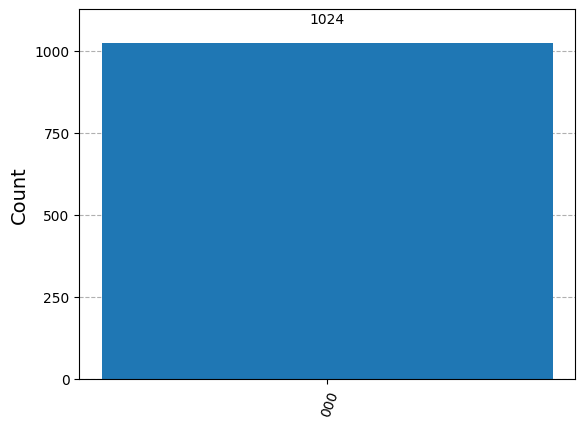

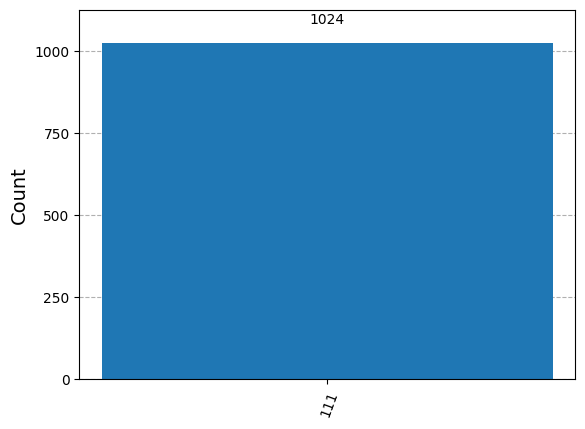

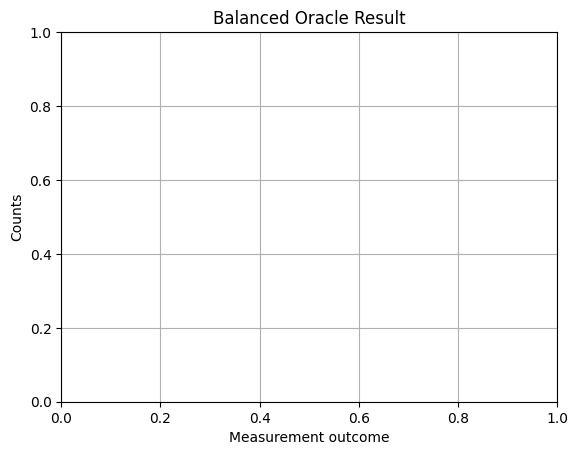

In [16]:

const_fig = plot_results(const_counts, "Constant Oracle Result")
display(const_fig)

balanced_fig = plot_results(balanced_counts, "Balanced Oracle Result")
display(balanced_fig)

plt.close(const_fig)
plt.close(balanced_fig)

In [10]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=0)
isa_qc_const = pm.run(qc_const)
isa_qc_balanced = pm.run(qc_bal)


Hardware simulation counts for constant oracle Counter({'000': 923, '001': 73, '010': 21, '100': 5, '111': 1, '011': 1})
Hardware simulation counts for balanced oracle Counter({'111': 927, '110': 39, '101': 23, '011': 19, '000': 5, '001': 4, '100': 4, '010': 3})


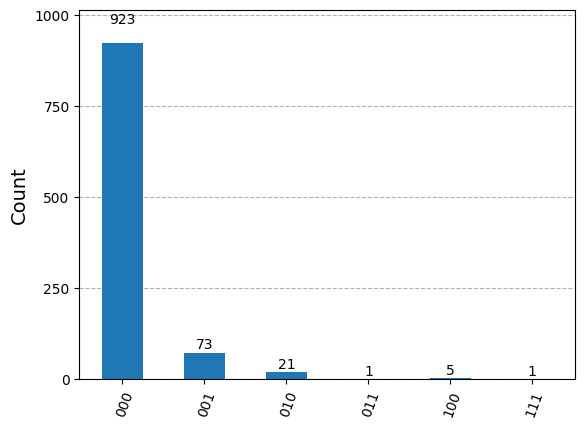

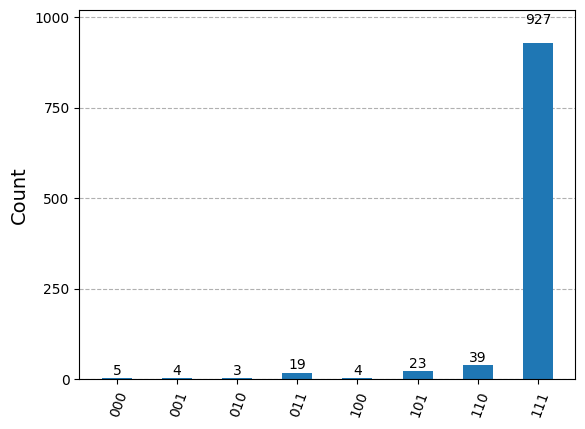

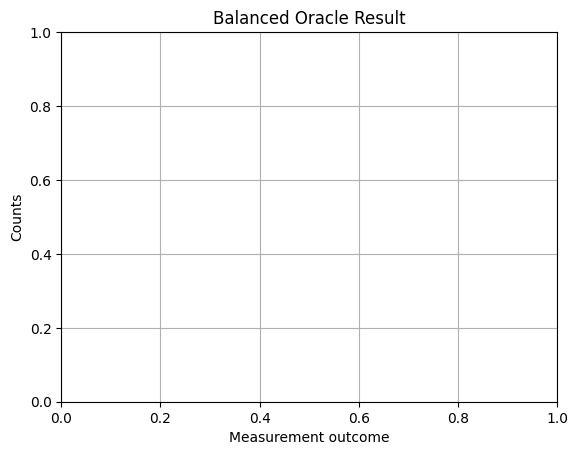

In [11]:
sampler = Sampler(backend)

job_const = sampler.run([isa_qc_const], shots=1024)
job_balanced = sampler.run([isa_qc_balanced], shots=1024)

#print(f"Constant circuit job ID: {job_const.job_id}")
#print(f"Balanced circuit job ID: {job_balanced.job_id}")

result_const = job_const.result()
result_balanced = job_balanced.result()

pub_result_const = result_const[0]
pub_result_balanced = result_balanced[0]

#access the bitstrings from the 'c' attribute of the DataBin
bitstrings_data_const = pub_result_const.data.c
bitstrings_data_balanced = pub_result_balanced.data.c

#convert the bitstrings to a list of binary strings by accessing the internal array
binary_strings1 = [bin(int.from_bytes(x, byteorder='big'))[2:].zfill(bitstrings_data_const.num_bits) for x in bitstrings_data_const._array]
binary_strings2 = [bin(int.from_bytes(x, byteorder='big'))[2:].zfill(bitstrings_data_balanced.num_bits) for x in bitstrings_data_balanced._array]

#count the occurrences of each binary string
counts1 = Counter(binary_strings1)
counts2 = Counter(binary_strings2)

print("Hardware simulation counts for constant oracle", counts1)
print("Hardware simulation counts for balanced oracle", counts2)

const_fig = plot_results(counts1, "Constant Oracle Result")
display(const_fig)

balanced_fig = plot_results(counts2, "Balanced Oracle Result")
display(balanced_fig)


In [12]:
#counts_const = result_const.quasi_dists[0].binary_probabilities()
#counts_bal = result_balanced.quasi_dists[0].binary_probabilities()